## Find out what par params best reproduce Pal 5 fan

In [1]:
from __future__ import division, print_function

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline

# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
#import superfreq
#plt.style.use('apw-notebook')
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.util import rolling_window
from scipy.signal import argrelmin,argrelmax
from scipy.stats import scoreatpercentile
from scipy.integrate import quad
from matplotlib import cm
from tqdm import tqdm


import matplotlib as mpl
#x = gp.SphericalNFWPotential
#print(x)
#Data to see if stream matches observed quantities 
obs_oden = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/obs_RA.txt') 
OD = np.genfromtxt('/Users/spearson/Dropbox/Pal5Bar_copy/OD_radec.txt')

from potential import get_bar_model


In [37]:
static_frame = gp.StaticFrame(units=galactic)

In [2]:
S = np.load('../data/Sn9l19m.npy') #expansion coeff.

# TODO: remove this line
S = S[:6, :8, :8]
S.size

384

## Various potentials used
Loop over various pars with different $M$, $\Omega$, $r_s$

In [88]:
Om = np.arange(25,65,5) #Array of pattern speeds, we are testing
mw = gp.BovyMWPotential2014()
potentials = []
for omega in Om*u.km/u.s/u.kpc:
    pot = gp.CCompositePotential()
    pot['disk'] = mw['disk']
    pot['halo'] = mw['halo']
    pot['bar'] = get_bar_model(Omega=omega, Snlm=S) #set alpha 
    #print(pot['bar'])
    frame = gp.ConstantRotatingFrame(Omega=[0,0,-1] * omega, units=galactic)
    H = gp.Hamiltonian(pot, frame)
    potentials.append(H)
len(potentials)    

8

In [90]:
#mw['bulge']

In [61]:
# Also have a regular potential without bar
pot_nobar = mw


In [91]:
pot_flat = gp.CCompositePotential()
pot_flat['halo'] = gp.NFWPotential(m = mw['halo'].parameters['m'],
                                  r_s = mw['halo'].parameters['r_s'],
                                  c = 0.5, units=galactic)
pot_flat['disk'] = mw['disk']
pot_flat['bulge'] = mw['bulge']

pot_nobar_flat  = pot_flat

In [33]:
# Setting Sun's params - should update distance
v_lsr = [11.1, 24.0, 7.25]*u.km/u.s
v_circ = 220*u.km/u.s
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc)
sun_frame = dict(vlsr=v_lsr, vcirc=v_circ, galactocentric_frame=galcen_frame)

In [34]:
v_sun = coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree,
                   distance=22.9*u.kpc,
                   pm_ra_cosdec=-2.296*u.mas/u.yr,
                   pm_dec=-2.257*u.mas/u.yr,
                   radial_velocity=-58.7*u.km/u.s)

w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)

In [35]:
n_steps=8000
forw_orbit = []#np.zeros([n_steps+1,len(pot)])
for i in range(len(potentials)):
    orbit = potentials[i].integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
    forw_orbit.append(orbit[::-1])

In [101]:
#ALSO DO IN NON-BARRED POT

orbit = pot_nobar.integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
forw_orbit_nobar = orbit[::-1]

In [102]:
## ALSO DO IN FLATTENED POTENTIAL
orbit = pot_nobar_flat.integrate_orbit(w0, dt=-0.5, n_steps=n_steps, Integrator=gi.DOPRI853Integrator)
forw_orbit_flat = orbit[::-1]

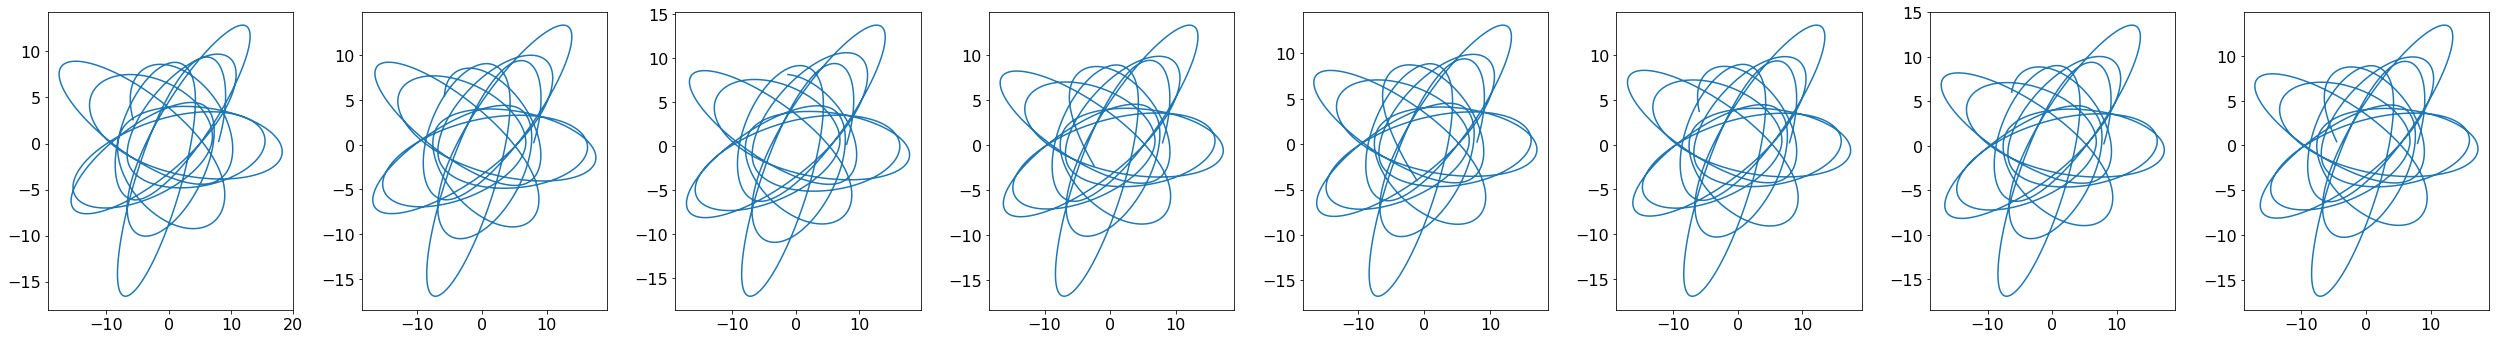

In [48]:
fig,axes = plt.subplots(1,len(potentials),figsize=(35,5))
for i in range(len(potentials)):
    orbit = forw_orbit[i].to_frame(static_frame)

   # mpl.rcParams.update({'font.size': 22})
    label_size = 18
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
  #  print(forw_orbit[i].x[0]) #check that orbits are slightly different 
    axes[i].plot(orbit.x, orbit.y )

    fig.tight_layout()
#fig.savefig('Fig1.pdf',dpi=400)

In [47]:
stream = []
for i in tqdm(range(len(potentials))):
    stream_data = gd.mockstream.fardal_stream(potentials[i], forw_orbit[i], 5E4*u.Msun, release_every=10)
    stream.append(stream_data)

100%|██████████| 8/8 [20:30<00:00, 164.09s/it]


In [103]:
##ALSO IN NON-BARRED POT
stream_nobar = gd.mockstream.fardal_stream(pot_nobar, forw_orbit_nobar, 5E4*u.Msun, release_every=10)
sim_c_nobar = stream_nobar.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

In [104]:
##ALSO Flattened potential
stream_flat = gd.mockstream.fardal_stream(pot_nobar_flat, forw_orbit_flat, 5E4*u.Msun, release_every=10)
sim_c_flat = stream_flat.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

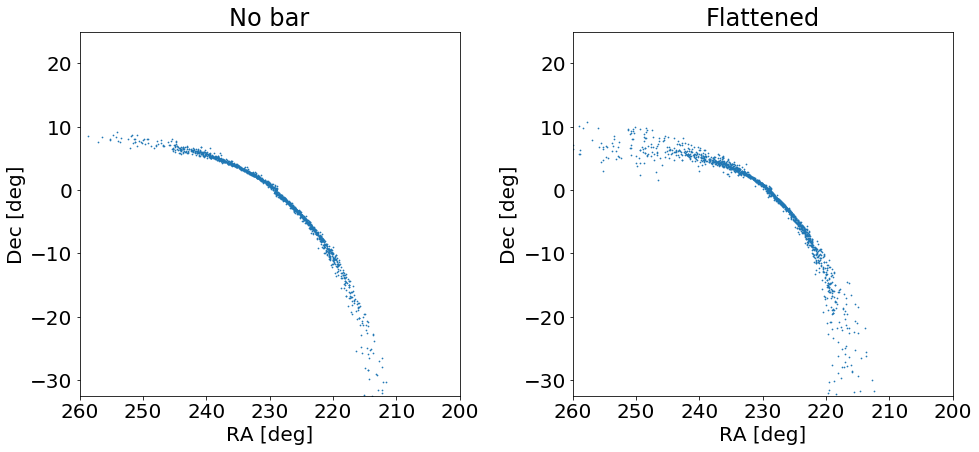

In [108]:

fig,axes = plt.subplots(1,2,figsize=(14,7))
mpl.rcParams.update({'font.size': 20})
label_size = 20
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 
axes[0].scatter(sim_c_nobar.ra, sim_c_nobar.dec,s=0.5)
axes[0].set_xlim(260,200)
axes[0].set_ylim(-32.5,25)
axes[0].set_aspect('equal')
axes[0].set_xlabel('RA [deg]')
axes[0].set_ylabel('Dec [deg]')
axes[0].set_title('No bar') #make sure I grab correct Om. 

axes[1].scatter(sim_c_flat.ra, sim_c_flat.dec,s=0.5)
axes[1].set_xlim(260,200)
axes[1].set_ylim(-32.5,25)
axes[1].set_aspect('equal')
axes[1].set_xlabel('RA [deg]')
axes[1].set_ylabel('Dec [deg]')
axes[1].set_title('Flattened') #make sure I grab correct Om. 
    
fig.tight_layout()
fig.savefig('/Users/spearson/Dropbox/AnaPal5/Pal5_morph_nobar_flat.png')


In [49]:
ra = []
dec = []
distance = []
pm_ra = []
pm_dec = []
vr = []
for i in range(len(potentials)):
    sim_c = stream[i].to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    ra.append(sim_c.ra)
    dec.append(sim_c.dec)
    distance.append(sim_c.distance)
    pm_ra.append(sim_c.pm_ra_cosdec)
    pm_dec.append(sim_c.pm_dec)
    vr.append(sim_c.radial_velocity)

## Look for length, leading fan, trailing gap

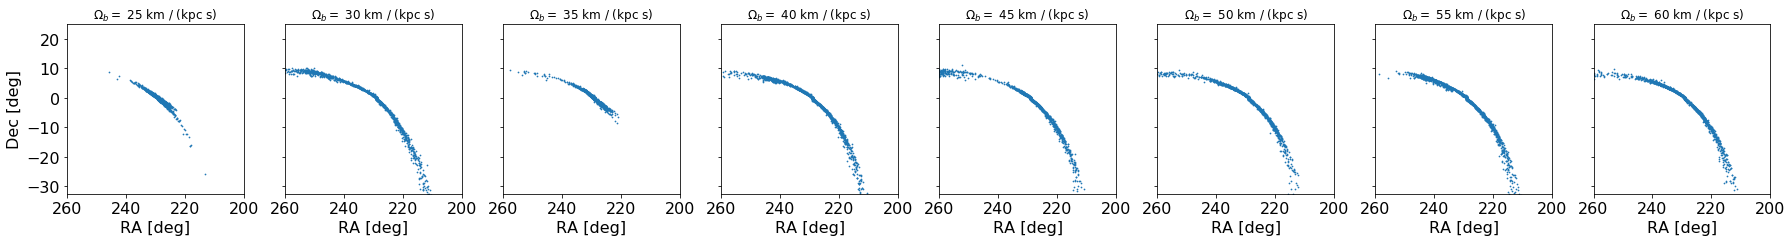

In [71]:
fig,axes = plt.subplots(1,len(potentials),figsize=(25,5), sharey=True)
axes[0].set_ylabel('Dec [deg]')
for i in range(len(potentials)):

    mpl.rcParams.update({'font.size': 10})
    label_size = 10
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
    axes[i].scatter(ra[i],dec[i] , s=0.5)
    axes[i].set_xlim(260,200)
    axes[i].set_ylim(-32.5,25)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('RA [deg]')
    axes[i].set_title('$\Omega_b = $ '+ str(np.int(Om[i])) + ' km / (kpc s)')

    fig.tight_layout()
#fig.savefig('Fig1.pdf',dpi=400)

## Save all snapshots to compare bar models

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

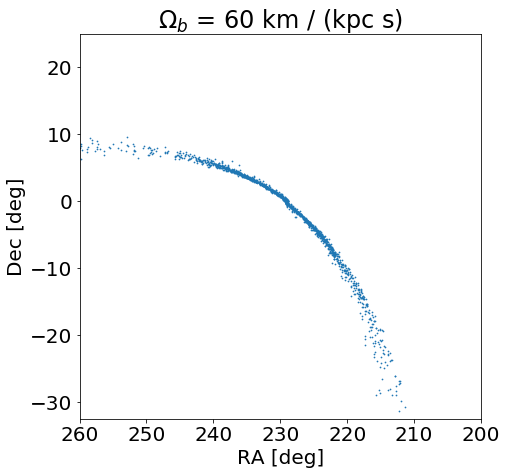

In [83]:

for i in range(len(potentials)):
    fig.clf()
    fig,axes = plt.subplots(1,figsize=(9,7), sharey=True)
    mpl.rcParams.update({'font.size': 20})
    label_size = 20
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
    axes.scatter(ra[i],dec[i] , s=0.5)
    axes.set_xlim(260,200)
    axes.set_ylim(-32.5,25)
    axes.set_aspect('equal')
    axes.set_xlabel('RA [deg]')
    axes.set_ylabel('Dec [deg]')
    axes.set_title('$\Omega_b$ = '+ str(Om[i]) + ' km / (kpc s)') #make sure I grab correct Om. 
    fig.savefig('/Users/spearson/Dropbox/AnaPal5/Pal5_morph_Om_'+ str(Om[i]) + '.png')
    
    fig.tight_layout()
#fig.savefig('Fig1.pdf',dpi=400)

## Look at distance, radial velocity of each barred sim

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

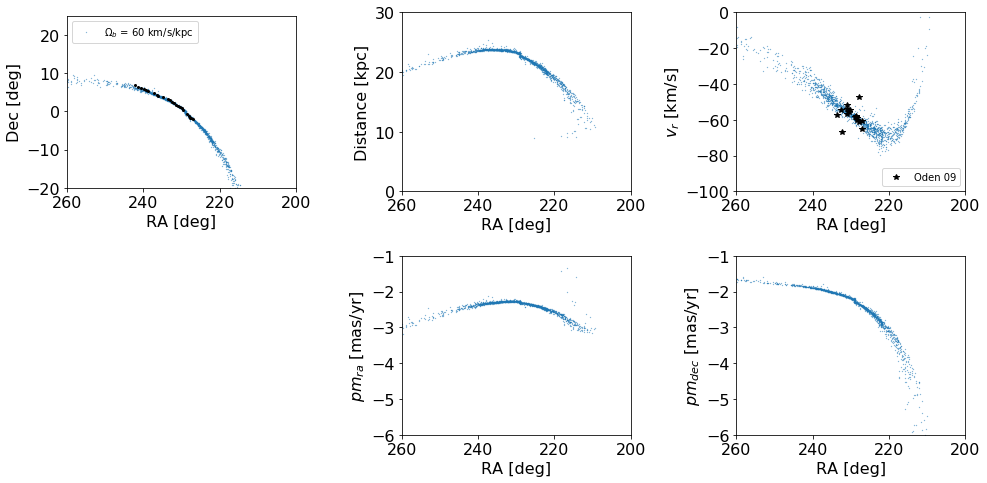

In [52]:

for i in range(len(potentials)):
    fig.clf()
    fig,axes = plt.subplots(2,3,figsize=(14,7))
    mpl.rcParams.update({'font.size': 16})
    label_size = 16
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size 
    axes[0,0].scatter(ra[i],dec[i] , s=0.05, label='$\Omega_b$ = '+ str(Om[i]) + " km/s/kpc")
    axes[0,0].plot(OD[:,0], OD[:,1], marker='.', markersize=4, linestyle='none', color='black')
    axes[0,0].set_xlim(260,200)
    axes[0,0].set_ylim(-20,25)
    axes[0,0].set_aspect('equal')
    axes[0,0].set_xlabel('RA [deg]')
    axes[0,0].set_ylabel('Dec [deg]')
    axes[0,0].legend(loc="upper left", fontsize=10)
    
    axes[0,1].scatter(ra[i],distance[i] , s=0.05)
    axes[0,1].set_ylim(0,30)
    axes[0,1].set_xlim(260,200)
    #axes[0,1].set_aspect('equal')
    axes[0,1].set_xlabel('RA [deg]')
    axes[0,1].set_ylabel('Distance [kpc]')
    
    axes[0,2].scatter(ra[i],vr[i] , s=0.05)
    axes[0,2].plot(obs_oden[:,0],obs_oden[:,1],  marker='*', color='black', linestyle='none', label='Oden 09')
    axes[0,2].set_xlim(260,200)
    axes[0,2].set_ylim(-100,0)
    #axes[0,1].set_aspect('equal')
    axes[0,2].set_xlabel('RA [deg]')
    axes[0,2].set_ylabel('$v_r$ [km/s]')
    axes[0,2].legend(loc='lower right', fontsize=10)
    
    
    axes[1,1].scatter(ra[i],pm_ra[i] , s=0.05)
    axes[1,1].set_xlim(260,200)
    axes[1,1].set_ylim(-6,-1)
    axes[1,1].set_xlabel('RA [deg]')
    axes[1,1].set_ylabel('$pm_{ra}$ [mas/yr]')
    
    
    axes[1,2].scatter(ra[i],pm_dec[i] , s=0.05)
    axes[1,2].set_xlim(260,200)
    axes[1,2].set_ylim(-6,-1)
    axes[1,2].set_xlabel('RA [deg]')
    axes[1,2].set_ylabel('$pm_{dec}$ [mas/yr]')
    
    axes[1,0].axis('off')
 

    #fig.set_title('$\Omega_b$ = '+ str(Om), fontsize=24)#, y=1.03)
    #fig.suptitle('$\Omega_b$ = '+ str(Om), fontsize=24, y=1.03)
    fig.tight_layout()
    fig.savefig('/Users/spearson/Dropbox/AnaPal5/Pal5_vel_Om_{:02d}.png'.format(int(Om[i])))
 


In [218]:
OD

array([[242.10179358,   6.95139634],
       [241.28829439,   6.42959651],
       [240.57769415,   6.06529658],
       [239.90939434,   5.76389664],
       [239.36479453,   5.57499646],
       [238.78859417,   5.4306968 ],
       [237.10149409,   4.78009702],
       [236.39199395,   4.35139694],
       [236.08099389,   4.00659709],
       [234.73509405,   3.71149692],
       [233.50659376,   3.14949722],
       [232.9261939 ,   2.87259698],
       [232.35779357,   2.46449769],
       [231.82929359,   2.1366975 ],
       [231.53119415,   1.81779716],
       [230.89799357,   1.50029717],
       [230.48979373,   1.1314971 ],
       [229.86639353,   0.78299731],
       [229.48539336,   0.37769726],
       [227.96579331,  -1.23900258],
       [228.63819305,  -0.64750226],
       [227.73339315,  -1.59610249],
       [227.47349316,  -1.84290181],
       [227.03319327,  -1.88400207]])